## Challenge
## In this module, we learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a house price dataset from Kaggle. In this challenge, you will keep working on this dataset.

## The scenario
## The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

## The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

## In this challenge, you are required to improve your model with respect to its prediction performance.

## To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer, roc_auc_score

from category_encoders import LeaveOneOutEncoder

from sklearn.model_selection import GridSearchCV

from sqlalchemy import create_engine

import warnings

warnings.filterwarnings('ignore')

## 1) Load the houseprices data from Thinkful's database.

In [55]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

#house_df = pd.read_sql_query('select * from houseprices',con=engine)
house_df = pd.read_csv('data/houseprices.csv')

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [56]:
house_df.shape

(1460, 81)

In [3]:
house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
house_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 2) Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [5]:
# Paved is only Y or N
house_df = house_df[house_df['paveddrive'] != 'P']

In [6]:
house_df.isna().mean()

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177622
lotarea          0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 81, dtype: float64

In [7]:
house_df['lotfrontage'] = house_df['lotfrontage'].fillna(house_df['lotfrontage'].mean())

In [8]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1430 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1430 non-null   int64  
 1   mssubclass     1430 non-null   int64  
 2   mszoning       1430 non-null   object 
 3   lotfrontage    1430 non-null   float64
 4   lotarea        1430 non-null   int64  
 5   street         1430 non-null   object 
 6   alley          84 non-null     object 
 7   lotshape       1430 non-null   object 
 8   landcontour    1430 non-null   object 
 9   utilities      1430 non-null   object 
 10  lotconfig      1430 non-null   object 
 11  landslope      1430 non-null   object 
 12  neighborhood   1430 non-null   object 
 13  condition1     1430 non-null   object 
 14  condition2     1430 non-null   object 
 15  bldgtype       1430 non-null   object 
 16  housestyle     1430 non-null   object 
 17  overallqual    1430 non-null   int64  
 18  overallc

In [9]:
house_df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [10]:
cols = ['mszoning', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 
           'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
           'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical',
           'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
           'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
           'garagecond', 'paveddrive', 'threessnporch', 'screenporch', 'poolarea', 'poolqc', 'fence', 'miscfeature', 
           'miscval', 'saletype', 'salecondition', 'landcontour', 'utilities', 'lotconfig', 'landslope']
for col in cols:
    print(house_df[col].value_counts())
    print('  ')

RL         1133
RM          207
FV           65
RH           15
C (all)      10
Name: mszoning, dtype: int64
  
Gable      1115
Hip         283
Flat         13
Gambrel      10
Mansard       7
Shed          2
Name: roofstyle, dtype: int64
  
CompShg    1404
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: roofmatl, dtype: int64
  
VinylSd    512
HdBoard    218
MetalSd    214
Wd Sdng    198
Plywood    107
CemntBd     61
BrkFace     48
WdShing     24
Stucco      23
AsbShng     18
Stone        2
BrkComm      2
CBlock       1
AsphShn      1
ImStucc      1
Name: exterior1st, dtype: int64
  
VinylSd    500
MetalSd    209
HdBoard    204
Wd Sdng    189
Plywood    139
CmentBd     60
Wd Shng     36
BrkFace     24
Stucco      24
AsbShng     18
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: exterior2nd, dtype: int64
  
None       837
BrkFace    443
Stone      127
BrkCmn      15
Name

In [11]:
# Drop columns with unnecessary values
drop_cols = ['mszoning', 'roofstyle', 'roofmatl', 'masvnrtype', 'alley',
           'exterqual', 'extercond', 'bsmtqual', 'electrical',
           'functional', 'garageyrblt', 'garagecars', 'garagequal', 'threessnporch', 'screenporch',
           'garagecond', 'poolarea', 'poolqc', 'miscfeature', 'miscval', 'saletype', 'salecondition',
           'landcontour', 'utilities', 'lotconfig', 'landslope', 'lotshape', 'bldgtype', 'street',
            'yearbuilt', 'yearremodadd']
house_df = house_df.drop(columns=drop_cols)

In [12]:
house_df.isna().mean()

id               0.000000
mssubclass       0.000000
lotfrontage      0.000000
lotarea          0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrarea       0.005594
foundation       0.000000
bsmtcond         0.025175
bsmtexposure     0.025874
bsmtfintype1     0.025175
bsmtfinsf1       0.000000
bsmtfintype2     0.025874
bsmtfinsf2       0.000000
bsmtunfsf        0.000000
totalbsmtsf      0.000000
heating          0.000000
heatingqc        0.000000
centralair       0.000000
firstflrsf       0.000000
secondflrsf      0.000000
lowqualfinsf     0.000000
grlivarea        0.000000
bsmtfullbath     0.000000
bsmthalfbath     0.000000
fullbath         0.000000
halfbath         0.000000
bedroomabvgr     0.000000
kitchenabvgr     0.000000
kitchenqual      0.000000
totrmsabvgrd     0.000000
fireplaces       0.000000
fireplacequ 

In [13]:
# Fill Nulls with 'None'
house_df['fireplacequ'] = house_df['fireplacequ'].fillna('None')
house_df['fence'] = house_df['fence'].fillna('None')

In [14]:
house_df.isna().mean()

id               0.000000
mssubclass       0.000000
lotfrontage      0.000000
lotarea          0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrarea       0.005594
foundation       0.000000
bsmtcond         0.025175
bsmtexposure     0.025874
bsmtfintype1     0.025175
bsmtfinsf1       0.000000
bsmtfintype2     0.025874
bsmtfinsf2       0.000000
bsmtunfsf        0.000000
totalbsmtsf      0.000000
heating          0.000000
heatingqc        0.000000
centralair       0.000000
firstflrsf       0.000000
secondflrsf      0.000000
lowqualfinsf     0.000000
grlivarea        0.000000
bsmtfullbath     0.000000
bsmthalfbath     0.000000
fullbath         0.000000
halfbath         0.000000
bedroomabvgr     0.000000
kitchenabvgr     0.000000
kitchenqual      0.000000
totrmsabvgrd     0.000000
fireplaces       0.000000
fireplacequ 

In [15]:
# Drop rest of Null rows
house_df = house_df.dropna()

In [16]:
house_df.head()

,id,mssubclass,lotfrontage,lotarea,neighborhood,condition1,condition2,housestyle,overallqual,overallcond,...,garagefinish,garagearea,paveddrive,wooddecksf,openporchsf,enclosedporch,fence,mosold,yrsold,saleprice
0,1,60,65.0,8450,CollgCr,Norm,Norm,2Story,7,5,...,RFn,548,Y,0,61,0,None,2,2008,208500
1,2,20,80.0,9600,Veenker,Feedr,Norm,1Story,6,8,...,RFn,460,Y,298,0,0,None,5,2007,181500
2,3,60,68.0,11250,CollgCr,Norm,Norm,2Story,7,5,...,RFn,608,Y,0,42,0,None,9,2008,223500
3,4,70,60.0,9550,Crawfor,Norm,Norm,2Story,7,5,...,Unf,642,Y,0,35,272,None,2,2006,140000
4,5,60,84.0,14260,NoRidge,Norm,Norm,2Story,8,5,...,RFn,836,Y,192,84,0,None,12,2008,250000


In [17]:
house_df.shape

(1312, 50)

In [18]:
house_df

,id,mssubclass,lotfrontage,lotarea,neighborhood,condition1,condition2,housestyle,overallqual,overallcond,...,garagefinish,garagearea,paveddrive,wooddecksf,openporchsf,enclosedporch,fence,mosold,yrsold,saleprice
0,1,60,65.0,8450,CollgCr,Norm,Norm,2Story,7,5,...,RFn,548,Y,0,61,0,None,2,2008,208500
1,2,20,80.0,9600,Veenker,Feedr,Norm,1Story,6,8,...,RFn,460,Y,298,0,0,None,5,2007,181500
2,3,60,68.0,11250,CollgCr,Norm,Norm,2Story,7,5,...,RFn,608,Y,0,42,0,None,9,2008,223500
3,4,70,60.0,9550,Crawfor,Norm,Norm,2Story,7,5,...,Unf,642,Y,0,35,272,None,2,2006,140000
4,5,60,84.0,14260,NoRidge,Norm,Norm,2Story,8,5,...,RFn,836,Y,192,84,0,None,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,Gilbert,Norm,Norm,2Story,6,5,...,RFn,460,Y,0,40,0,None,8,2007,175000
1456,1457,20,85.0,13175,NWAmes,Norm,Norm,1Story,6,6,...,Unf,500,Y,349,0,0,MnPrv,2,2010,210000
1457,1458,70,66.0,9042,Crawfor,Norm,Norm,2Story,7,9,...,RFn,252,Y,0,60,0,GdPrv,5,2010,266500
1458,1459,20,68.0,9717,NAmes,Norm,Norm,1Story,5,6,...,Unf,240,Y,366,0,112,None,4,2010,142125


## Find and handle outliers

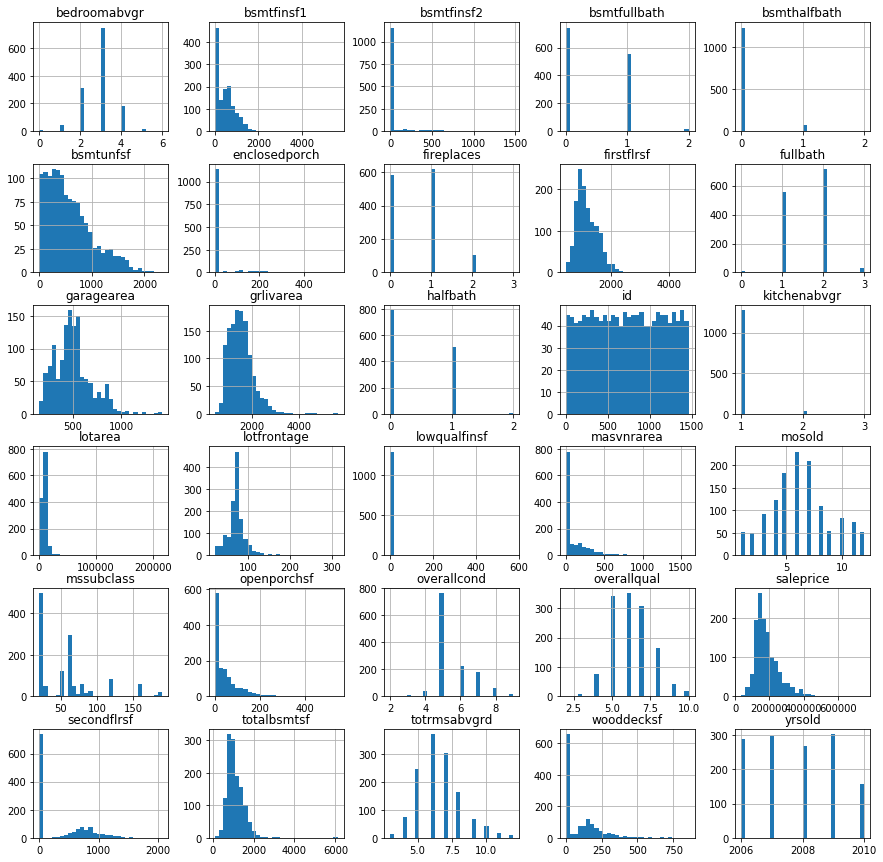

In [19]:
numerics = ['uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = house_df.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

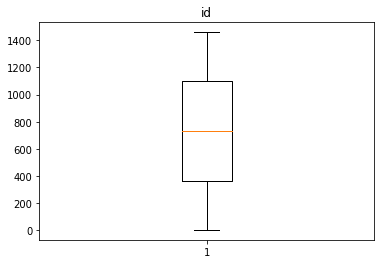

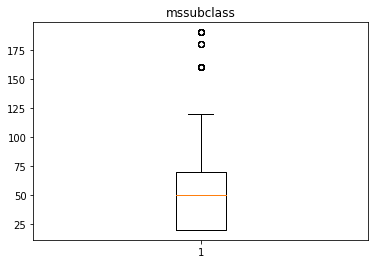

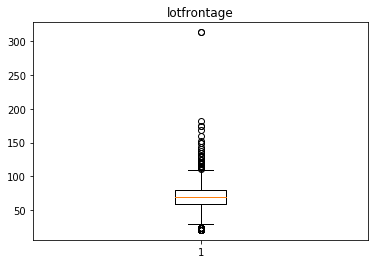

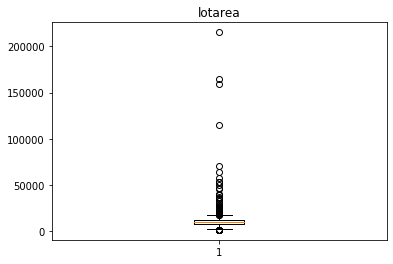

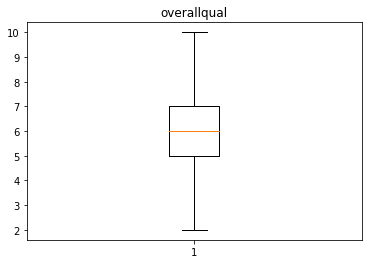

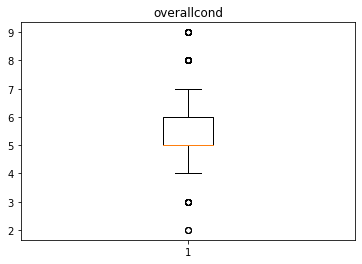

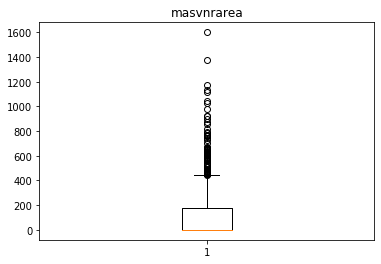

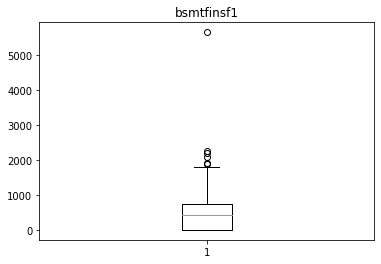

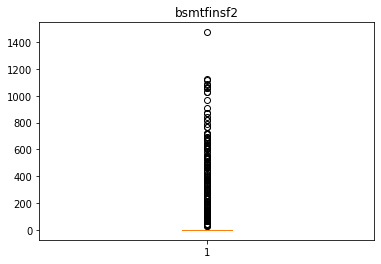

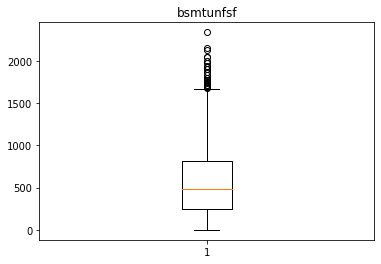

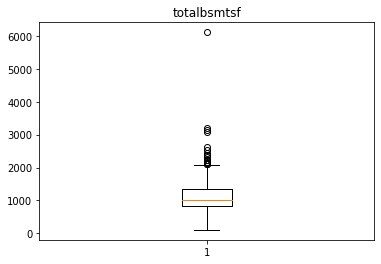

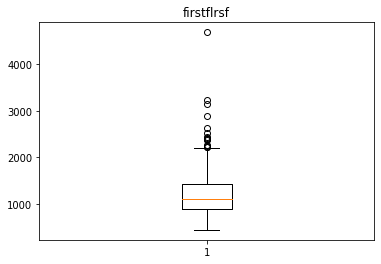

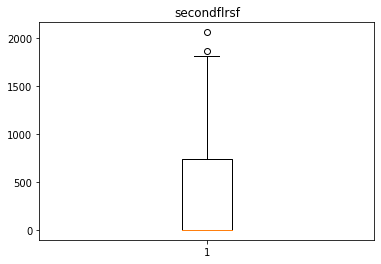

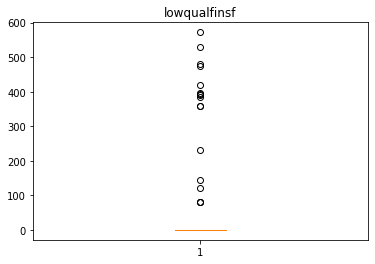

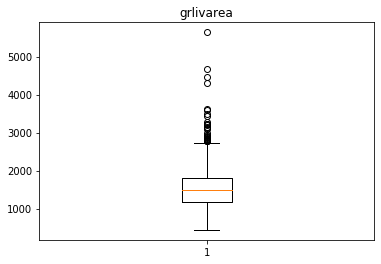

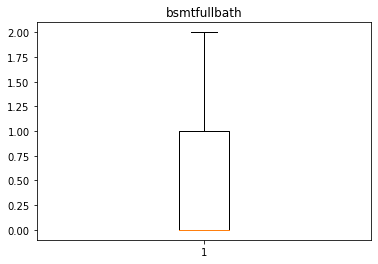

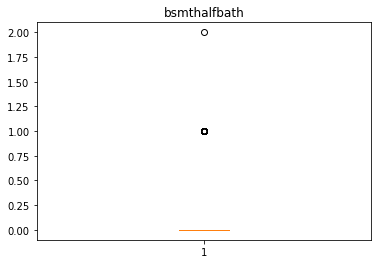

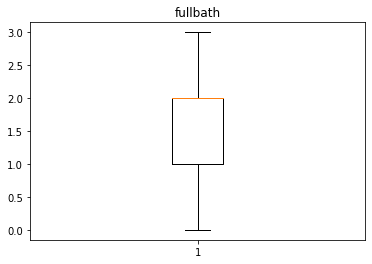

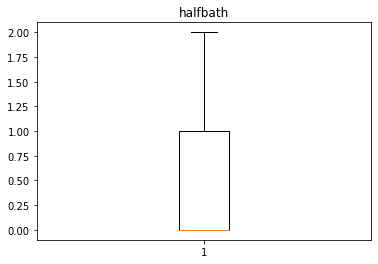

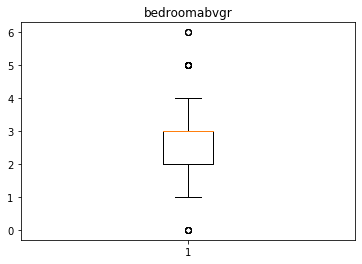

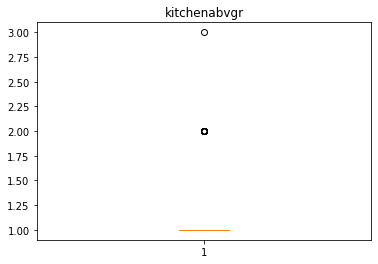

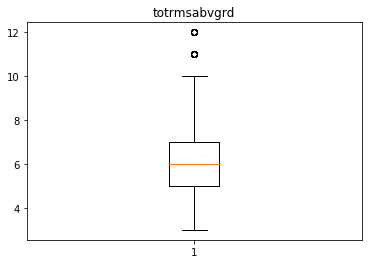

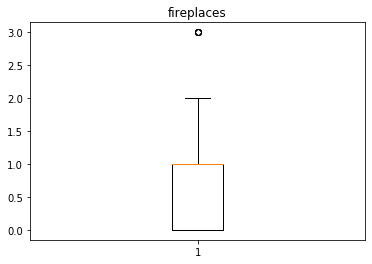

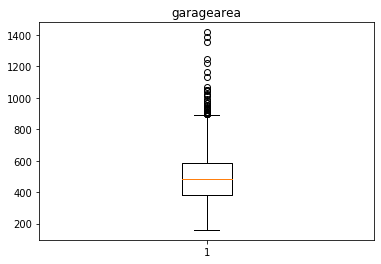

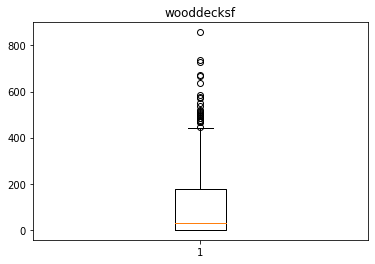

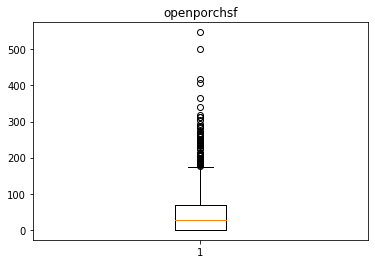

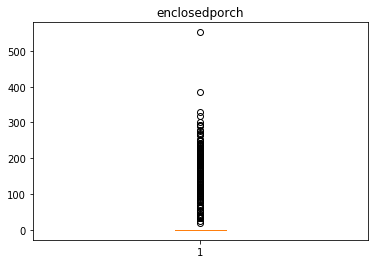

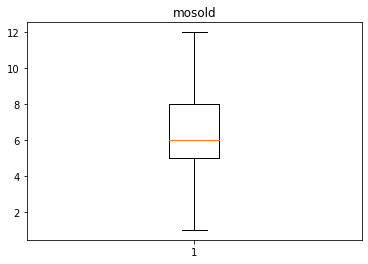

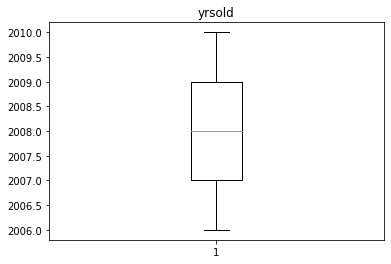

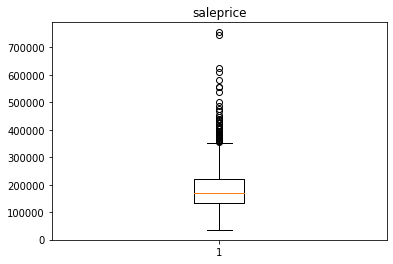

In [20]:
cols = numeric_df.columns
for col in cols:
    plt.boxplot(house_df[col])
    plt.title(col)
    plt.show()

## Winsorize values

In [21]:
for col in cols:
    house_df[col] = winsorize(house_df[col], (0, 0.10))

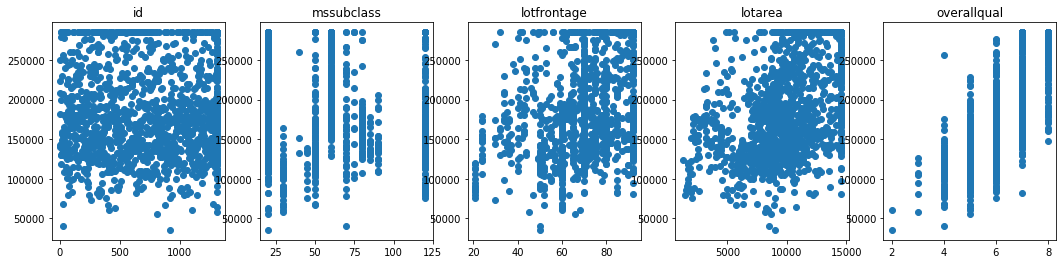

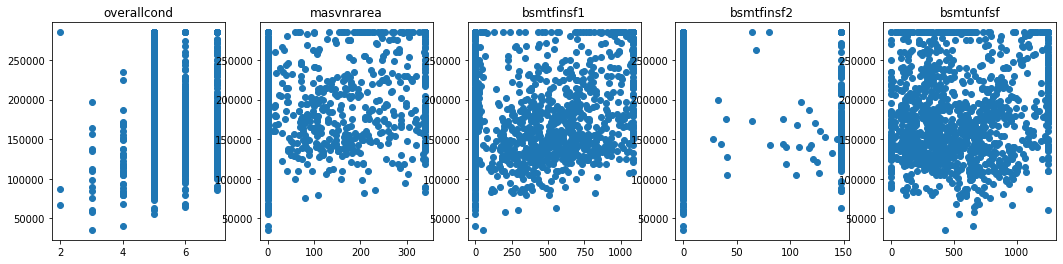

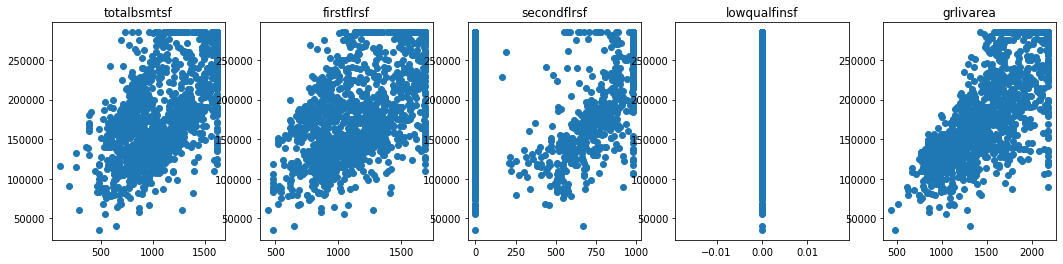

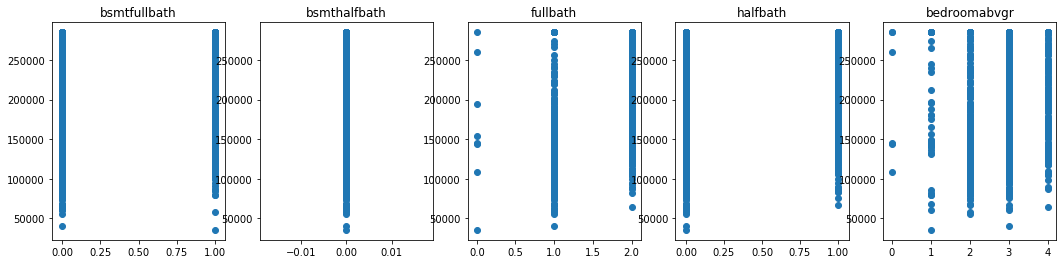

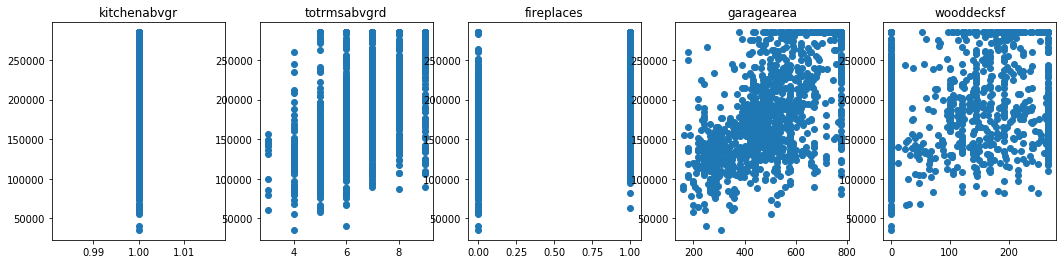

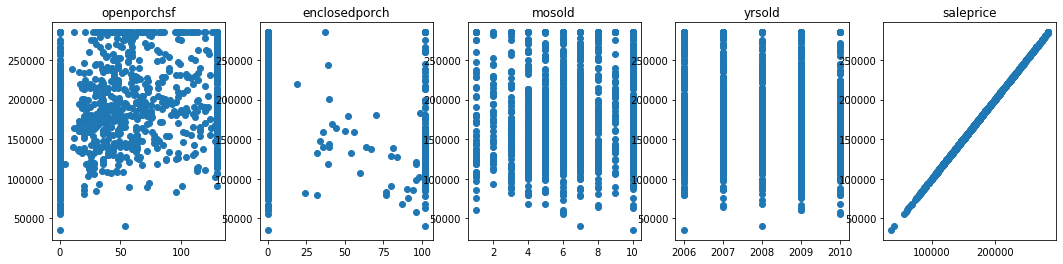

<Figure size 1296x288 with 0 Axes>

In [22]:
x = 1
plt.figure(figsize=(18,4))
for col in cols:
    plt.subplot(1,5,x)
    plt.scatter(house_df[col], house_df["saleprice"])
    plt.title(col)
    
    if (x == 5):
        x = 1
        plt.show()
        plt.figure(figsize=(18,4))
    else:
        x += 1

## Correlation matrix and heat map

In [23]:
corrmat = house_df.corr()
corrmat

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,kitchenabvgr,totrmsabvgrd,fireplaces,garagearea,wooddecksf,openporchsf,enclosedporch,mosold,yrsold,saleprice
id,1.000000,0.016365,-0.024459,-0.018390,-0.047331,0.004063,-0.042647,-0.006441,-0.004048,-0.014315,...,NaN,0.012150,-0.006108,0.007369,-0.048481,-0.025109,0.003273,0.023927,-0.001576,-0.030009
mssubclass,0.016365,1.000000,-0.427902,-0.429176,0.117886,-0.117770,0.037616,-0.061532,-0.077842,-0.115838,...,NaN,0.026145,0.034919,-0.052516,0.017369,0.012554,-0.039888,0.002165,-0.023869,-0.025432
lotfrontage,-0.024459,-0.427902,1.000000,0.620774,0.182926,-0.022315,0.189380,0.126833,0.042425,0.109741,...,NaN,0.336112,0.207180,0.335813,0.096911,0.145116,-0.035866,0.025844,-0.002148,0.359787
lotarea,-0.018390,-0.429176,0.620774,1.000000,0.187209,-0.004778,0.142414,0.170231,0.068640,0.066857,...,NaN,0.417141,0.298263,0.340972,0.175252,0.152342,-0.025848,-0.000769,-0.031871,0.437730
overallqual,-0.047331,0.117886,0.182926,0.187209,1.000000,-0.196186,0.376769,0.095580,-0.149838,0.270946,...,NaN,0.434877,0.425596,0.522506,0.236539,0.368673,-0.168197,0.065855,-0.026188,0.800861
overallcond,0.004063,-0.117770,-0.022315,-0.004778,-0.196186,1.000000,-0.156660,-0.029053,0.092634,-0.166879,...,NaN,-0.091773,-0.072845,-0.229871,-0.040868,-0.127495,0.093542,-0.019669,0.043069,-0.123439
masvnrarea,-0.042647,0.037616,0.189380,0.142414,0.376769,-0.156660,1.000000,0.207007,-0.087064,0.070966,...,NaN,0.285581,0.254014,0.359375,0.149292,0.191052,-0.146891,0.003185,0.010569,0.408243
bsmtfinsf1,-0.006441,-0.061532,0.126833,0.170231,0.095580,-0.029053,0.207007,1.000000,-0.010562,-0.641270,...,NaN,-0.028564,0.142910,0.225168,0.172936,0.070820,-0.134187,-0.013457,0.023564,0.283026
bsmtfinsf2,-0.004048,-0.077842,0.042425,0.068640,-0.149838,0.092634,-0.087064,-0.010562,1.000000,-0.288717,...,NaN,-0.062526,-0.004049,-0.055756,0.064003,-0.073086,0.049374,-0.032318,0.032642,-0.086428
bsmtunfsf,-0.014315,-0.115838,0.109741,0.066857,0.270946,-0.166879,0.070966,-0.641270,-0.288717,1.000000,...,NaN,0.251319,0.086449,0.148741,-0.037423,0.129738,0.017108,0.030874,-0.040696,0.176303


In [24]:
house_df = house_df.drop(columns=['lowqualfinsf', 'bsmthalfbath', 'kitchenabvgr'])

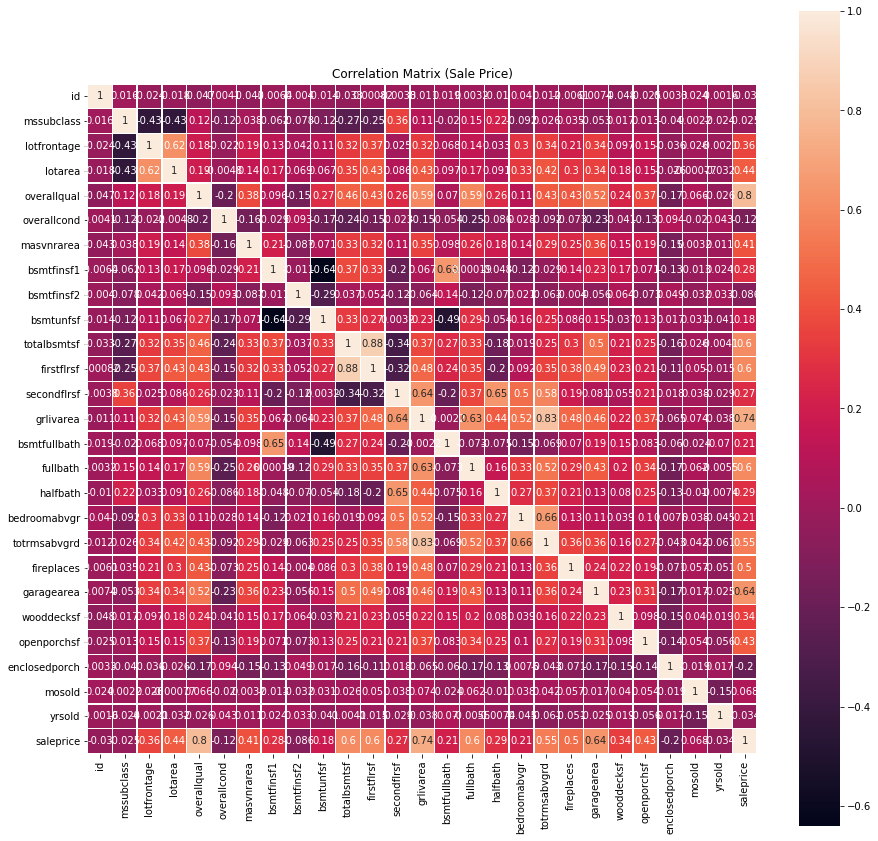

In [25]:
corrmap = house_df.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(corrmap, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Sale Price)")

plt.show()

In [26]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312 entries, 0 to 1459
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1312 non-null   int64  
 1   mssubclass     1312 non-null   int64  
 2   lotfrontage    1312 non-null   float64
 3   lotarea        1312 non-null   int64  
 4   neighborhood   1312 non-null   object 
 5   condition1     1312 non-null   object 
 6   condition2     1312 non-null   object 
 7   housestyle     1312 non-null   object 
 8   overallqual    1312 non-null   int64  
 9   overallcond    1312 non-null   int64  
 10  exterior1st    1312 non-null   object 
 11  exterior2nd    1312 non-null   object 
 12  masvnrarea     1312 non-null   float64
 13  foundation     1312 non-null   object 
 14  bsmtcond       1312 non-null   object 
 15  bsmtexposure   1312 non-null   object 
 16  bsmtfintype1   1312 non-null   object 
 17  bsmtfinsf1     1312 non-null   int64  
 18  bsmtfint

## Split relevent columns into numerical, categorical, and binary

In [27]:
house_df.columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'neighborhood',
       'condition1', 'condition2', 'housestyle', 'overallqual', 'overallcond',
       'exterior1st', 'exterior2nd', 'masvnrarea', 'foundation', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'firstflrsf', 'secondflrsf', 'grlivarea', 'bsmtfullbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenqual', 'totrmsabvgrd',
       'fireplaces', 'fireplacequ', 'garagetype', 'garagefinish', 'garagearea',
       'paveddrive', 'wooddecksf', 'openporchsf', 'enclosedporch', 'fence',
       'mosold', 'yrsold', 'saleprice'],
      dtype='object')

In [28]:
num_cols = ['totalbsmtsf', 'firstflrsf', 'grlivarea', 'garagearea']
cat_cols = ['mssubclass', 'overallqual', 'overallcond', 'fullbath', 'halfbath', 'totrmsabvgrd',
           'fireplaces', 'enclosedporch']
bin_cols = ['centralair', 'paveddrive']

## One Hot Encoding of cat_cols and bin_cols

In [29]:
for col in bin_cols:
    new_col = 'd_' + col
    house_df[new_col] = pd.get_dummies(house_df[col], drop_first=True)
    
bin_cols = ['d_centralair', 'd_paveddrive']

## Try OLS linear regression with different models

In [30]:
X = house_df[num_cols + cat_cols + bin_cols]
y = house_df['saleprice']

lrm = linear_model.LinearRegression()

lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     485.4
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:48:13   Log-Likelihood:                -15047.
No. Observations:                1312   AIC:                         3.012e+04
Df Residuals:                    1297   BIC:                         3.020e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.231e+05   7708.144    -15.964      0.000   -1.38e+05   -1.08e+05
totalbsmtsf      40.7534      4.501      9.054      0.000      31.923      49.584
firstflrsf       -5.1356      4.931     -1.041      0.298     -14.809       4.538
grlivarea        47.3648      3.838     12.342      0.000      39.836      54.893
garagearea       58.2808      5.181     11.249      0.000      48.117      68.445
mssubclass      -85.7189     21.563     -3.975      0.000    -128.021     -43.417
overallqual    1.842e+04    797.073     23.107      0.000    1.69e+04       2e+04
overallcond    6547.4657    783.363      8.358      0.000    5010.669    8084.263
fullbath       4753.2230   1861.410      2.554      0.011    1101.519    8404.927
halfbath       6951.4045   1861.662      3.734      0.000    3299.206    1.06e+04
totrmsabvgrd  -2270.9099    832.514     -2.728      0.006   -3904.132    -637.688
fireplaces     7890.0571   1562.866      5.048      0.000    4824.036     1.1e+04
enclosedporch   -66.6544     21.273     -3.133      0.002    -108.388     -24.921
d_centralair   1.411e+04   3498.934      4.033      0.000    7245.416     2.1e+04
d_paveddrive   8035.7809   3443.824      2.333      0.020    1279.706    1.48e+04
==============================================================================
Omnibus:                      113.415   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.458
Skew:                          -0.456   Prob(JB):                     1.41e-68
Kurtosis:                       5.210   Cond. No.                     2.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
X = house_df[['overallqual', 'overallcond', 'fullbath', 'halfbath', 'fireplaces', 'd_centralair', 'd_paveddrive']]
y = house_df['saleprice']

lrm = linear_model.LinearRegression()

lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     450.2
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:48:13   Log-Likelihood:                -15442.
No. Observations:                1312   AIC:                         3.090e+04
Df Residuals:                    1304   BIC:                         3.094e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.208e+04   9068.035    -10.154      0.000    -1.1e+05   -7.43e+04
overallqual   2.842e+04    962.285     29.534      0.000    2.65e+04    3.03e+04
overallcond   3874.4409   1009.227      3.839      0.000    1894.555    5854.327
fullbath       2.24e+04   2144.260     10.446      0.000    1.82e+04    2.66e+04
halfbath      7082.2915   1853.263      3.822      0.000    3446.588    1.07e+04
fireplaces    1.969e+04   1953.855     10.077      0.000    1.59e+04    2.35e+04
d_centralair  1.477e+04   4577.431      3.227      0.001    5792.437    2.38e+04
d_paveddrive  1.272e+04   4539.479      2.802      0.005    3814.583    2.16e+04
==============================================================================
Omnibus:                        5.324   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                5.428
Skew:                          -0.115   Prob(JB):                       0.0663
Kurtosis:                       3.215   Cond. No.                         93.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3) Now, split your data into train and test sets where 20% of the data resides in the test set.

In [34]:
X = house_df[['overallqual', 'fullbath', 'fireplaces', 'd_centralair', 'd_paveddrive']]
y = house_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 66)

## 4) Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [35]:
cat_cols = ['overallqual', 'fullbath', 'fireplaces', 'd_centralair', 'd_paveddrive']

In [36]:
# Categorical feature encoding
encoder = LeaveOneOutEncoder(cols=cat_cols)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

X_train.head(2)

,overallqual,fullbath,fireplaces,d_centralair,d_paveddrive
980,207361.186992,139909.069820,147686.435622,184067.479479,183176.383234
599,163572.070671,211184.053512,207148.576329,184067.479479,183176.383234


### Lasso

In [37]:
grid = {'cv': [1, 3, 5], "n_jobs": [0.1, 1, 10]}

model = GridSearchCV(
    LassoCV(),
    param_grid=grid
)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                               fit_intercept=True, max_iter=1000, n_alphas=100,
                               n_jobs=None, normalize=False, positive=False,
                               precompute='auto', random_state=None,
                               selection='cyclic', tol=0.0001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'cv': [1, 3, 5], 'n_jobs': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
model.best_params_

{'cv': 5, 'n_jobs': 1}

In [39]:
model.score(X_train, y_train)

0.7419051326815944

In [40]:
model.score(X_test, y_test)

0.6900859860508317

### Ridge

In [41]:
grid = {"cv": [1, 3, 5]}

model = GridSearchCV(
    RidgeCV(),
    param_grid=grid
)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None,
                               fit_intercept=True, gcv_mode=None,
                               normalize=False, scoring=None,
                               store_cv_values=False),
             iid='deprecated', n_jobs=None, param_grid={'cv': [1, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
model.best_params_

{'cv': 3}

In [43]:
model.score(X_train, y_train)

0.7419244556968059

In [44]:
model.score(X_test, y_test)

0.6901125212641247

### ElasticNet

In [45]:
grid = {"n_jobs": [0.1, 1, 10], "cv": [1, 3, 5]}

model = GridSearchCV(
    ElasticNetCV(),
    param_grid=grid
)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNetCV(alphas=None, copy_X=True, cv=None,
                                    eps=0.001, fit_intercept=True, l1_ratio=0.5,
                                    max_iter=1000, n_alphas=100, n_jobs=None,
                                    normalize=False, positive=False,
                                    precompute='auto', random_state=None,
                                    selection='cyclic', tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'cv': [1, 3, 5], 'n_jobs': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [46]:
model.best_params_

{'cv': 5, 'n_jobs': 1}

In [47]:
model.score(X_train, y_train)

0.7418815402349785

In [48]:
model.score(X_test, y_test)

0.6901999350540107

## 5) Evaluate your best model on the test set.

In [50]:
model = LassoCV(cv=5, n_jobs=1) 
model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [51]:
model.score(X_train, y_train)

0.7419051326815944

In [52]:
model.score(X_test, y_test)

0.6900859860508317

In [53]:
# We are making predictions here
y_preds_test = model.predict(X_test)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Mean absolute error of the prediction is: 23383.715536474472
Mean squared error of the prediction is: 932040869.366911
Root mean squared error of the prediction is: 30529.344397921668
Mean absolute percentage error of the prediction is: 14.776174944833373


## 6) So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.